In [1]:
using Revise
using Distributions, Plots, IJulia, DifferentialEquations, OptimizationOptimJL, DiffEqFlux, Optimization, IterTools

### CRM Differential Equation:

$$\frac{dq}{dt} = \frac{I\cdot F - \tau\cdot J\cdot \frac{dP}{dt} - q}{\tau}$$

### Feedforward Neural Network to compute $ \frac{dP}{dt}$

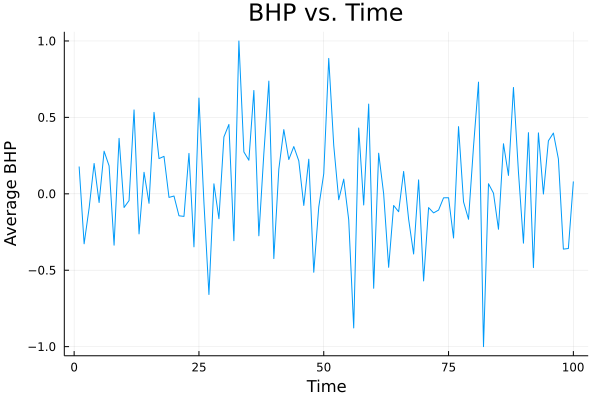

In [2]:
# create synthetic dataset
timesteps = collect(1.:1:100.)
timesteps_ = reshape(timesteps, 1,length(timesteps))
bhp = rand(Normal(1000, 200), length(timesteps))
bhp_norm = 2(bhp .- minimum(bhp))./(maximum(bhp) - minimum(bhp)) .- 1
plot(timesteps, bhp_norm, plot_title="BHP vs. Time", xlabel="Time", ylabel="Average BHP", legend=false)

In [38]:
batch_size = 32
train_loader = Flux.DataLoader((timesteps', bhp_norm'), batchsize=batch_size, shuffle=false)
# a trailing apostrophe is the adjoint (that is, the complex transpose) operator Aᴴ
num_epochs = 1000
opt = ADAM()
m = Chain(Dense(1, 30, sigmoid), Dense(30, 30, sigmoid), Dense(30, 1))
loss(x, y) = Flux.mse(m(x), y)
ps = Flux.params(m)

cb1 = function()
    # loss(timesteps', bhp_norm') < 0.0005 && Flux.stop()
    IJulia.clear_output(true)
    IJulia.display("Loss: $(loss(timesteps', bhp_norm'))")
    scatter(timesteps, bhp_norm, xlabel="Time", ylabel="BHP", labels="Synthetic Data")
    IJulia.display(plot!(timesteps, Float64.(vec(m(timesteps'))), xlabel="Time", ylabel="BHP", labels="NN(t)"))
end
# Flux.train!(loss, ps, ncycle(train_loader, num_epochs), opt, cb=cb1)
Flux.@epochs 1000 begin
    Flux.train!(loss, ps, train_loader, ADAM(), cb=cb1)
end
# bhp_trained = Float64.(vec(m(timesteps')))

Chain(
  Dense(1 => 30, σ),                    # 60 parameters
  Dense(30 => 30, σ),                   # 930 parameters
  Dense(30 => 1),                       # 31 parameters
)                   # Total: 6 arrays, 1_021 parameters, 4.363 KiB.

In [66]:
dp = Flux.jacobian(x -> ((m(x).+1)*0.5(maximum(bhp) - minimum(bhp)) .+ minimum(bhp)), timesteps')
δP(t) = dp[1][trunc(Int, t), trunc(Int, t)]

δP (generic function with 1 method)

### Forward solution of CRM

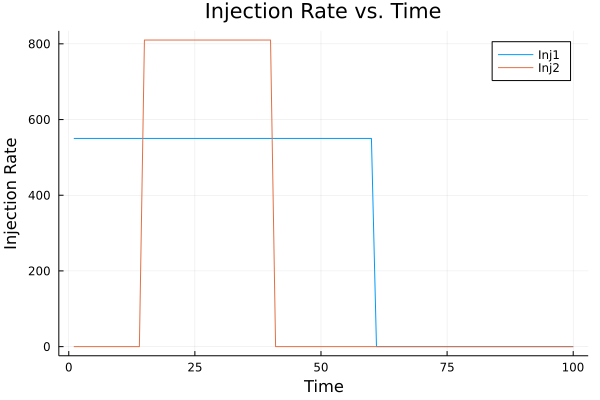

In [67]:
I1(t) = (60>=t) ? 550 : 0
I2(t) = (40>=t>=15) ? 810 : 0
plot(timesteps, I1, label="Inj1", xlabel="Time", ylabel="Injection Rate", title="Injection Rate vs. Time")
plot!(timesteps, I2, label="Inj2")

In [68]:
function crm_bhp!(du, u, p, t)
    q = u
    τ, J, F1, F2 = p
    du[1] = (I1(t)*F1 + I2(t)*F2 - τ*J*δP(t) - u[1]) / τ
end

crm_bhp! (generic function with 1 method)

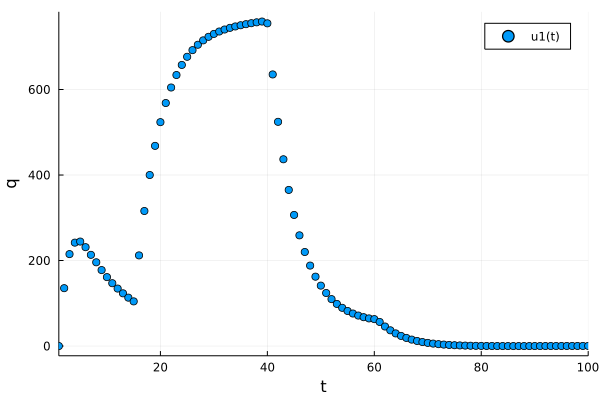

In [69]:
u0 = [0.0]
tspan = (minimum(timesteps), maximum(timesteps))
crm_params = [5.0, 1.0, 0.1, 0.9]
prob = ODEProblem(crm_bhp!, u0, tspan, crm_params, saveat=1)
sol = solve(prob, Tsit5())
scatter(sol, xlabel="t", ylabel="q")

In [74]:
function obj(p, x)
    prob_ = ODEProblem(crm_bhp!, x, tspan, p, saveat=1)
    sol_ = solve(prob_, Tsit5())
    return sum(abs2,Array(sol_) .- Array(sol))
end

obj (generic function with 1 method)

In [79]:
cons(res, p, x) = (res .= [p[3]+p[4]])
optprob = OptimizationFunction(obj, Optimization.AutoForwardDiff(), cons=cons)
initial = [6.0, 3.0, 0.2, 0.8]
lower = [0.0, 0.0, 0.0, 0.0]
upper = [10.0, 10.0, 1.0, 1.0]
prob2 = OptimizationProblem(optprob, initial, u0, lb=lower, ub=upper)
sol2 = solve(prob2, Optim.SAMIN(), iterations=14000) 
# Optim.Options(): manually set iterations, f_calls_limit, etc

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:           0.04653

       parameter      search width
         4.99996           0.00152 
         1.00011           0.00038 
         0.09997           0.00062 
         0.90006           0.00048 


u: 4-element Vector{Float64}:
 4.999955057550217
 1.0001081720180651
 0.0999733773157417
 0.9000574926129497

In [80]:
# compare with crm_params
crm_params

4-element Vector{Float64}:
 5.0
 1.0
 0.1
 0.9

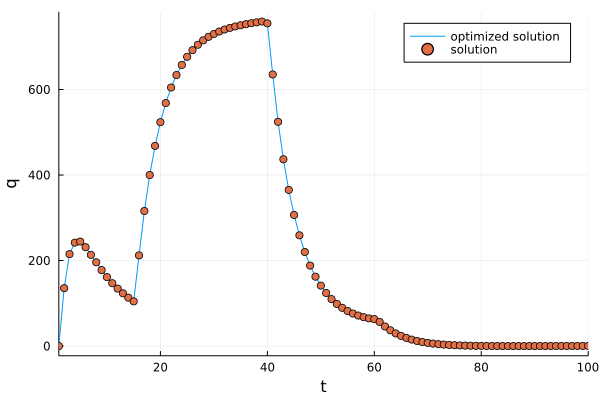

In [81]:
prob3 = ODEProblem(crm_bhp!, u0, tspan, sol2, saveat=1)
sol3 = solve(prob3, Tsit5())
plot(sol3, xlabel="t", ylabel="q", label="optimized solution")
scatter!(sol, label="solution")

### Future work

1. Compute connectivities as *kwargs (?)
2. NN: add validation and test; hyperparameter tuning

In [82]:
# model = Chain(Dense(1, 10, leakyrelu), Dense(10, 1, leakyrelu))
# params1 = Flux.params(model)
# loss1(x, y) = Flux.Losses.mse(model(x), y)

# cb1 = function()
#     # loss1(timesteps, bhp_norm) < 0.0005 && Flux.stop()
#     IJulia.clear_output(true)
#     IJulia.display("Loss: $(loss1(timesteps, bhp_norm))")
#     scatter(timesteps, bhp_norm, xlabel="Time", ylabel="BHP", labels="Synthetic Data")
#     IJulia.display(plot!(timesteps, model(timesteps), xlabel="Time", ylabel="BHP", labels="NN(t)"))
# end

# Flux.@epochs 1000 begin
#     Flux.train!(loss1, params1, Flux.DataLoader((timesteps, bhp_norm), batchsize=100), ADAM(), cb=cb1)
# end